# Modelo de detección de enfermedades de tiroides

Variante donde las clases se simplifican a "positive" (enfermo, ya sea por hipertiroidismo como por hipotiroidismo) y "negative" en la preparación de datos e implementando un modelo de regresión logística para predecir si un paciente tiene una enfermedad de tiroides o no.

## Definición del *pipeline*

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class AgeOutlierImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to handle age outliers by imputing values over 150 
    with the median age of the dataset.
    """
    def __init__(self, threshold=150):
        self.threshold = threshold
        self.median_age = None
        
    def fit(self, X, y=None):
        # Calculate median age excluding outliers
        self.median_age = np.median(X[X <= self.threshold])
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        mask = X_copy > self.threshold
        X_copy[mask] = self.median_age
        return X_copy

In [2]:
class TSHLogTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to handle TSH's right-skewed distribution 
    using log transformation with handling of zeros.
    """
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        # Add small constant before log transform to handle zeros
        return np.log1p(X_copy)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer


standard_numeric = ['TT4', 'T4U', 'FTI', 'T3']

# Special handling for TSH (right-skewed distribution)
tsh_feature = ['TSH']


# Binary categorical features
binary_features = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds',
                    'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
                    'query_hypothyroid', 'query_hyperthyroid', 'lithium',
                    'goitre', 'tumor', 'hypopituitary', 'psych']

# categorical categorical features
categorical_features = ['sex', 'referral_source']

# Create specialized pipelines
age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_handler', AgeOutlierImputer(threshold=150)),
    ('scaler', StandardScaler())
])

standard_numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

tsh_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', TSHLogTransformer()),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])


# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['age']),
        ('standard_numeric', standard_numeric_pipeline, standard_numeric),
        ('tsh', tsh_pipeline, tsh_feature),
        ('binary', OneHotEncoder(drop='if_binary', handle_unknown='ignore', 
                                 sparse_output=False), binary_features),
        ('categorical', categorical_pipeline, categorical_features),
    ],
    remainder='drop'
)


In [4]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
           ('preprocessor', preprocessor),
           ('classifier', LogisticRegression(
               solver='lbfgs',            # Algoritmo de optimización
               max_iter=1000,             # Máximo de iteraciones
               C=1.0,                     # Inverso de la regularización
               class_weight='balanced',   # Para manejar desbalanceo
               random_state=42
           ))
       ])

## *Pipeline* de entrenamiento

### Carga y preparación de datos

In [5]:
import pandas as pd
file_path = "./data/thyroidDF.csv"
df = pd.read_csv(file_path)

class_mapping = {
    '-': 'negative',
    'K': 'hyperthyroid', 'B': 'hyperthyroid', 'H|K': 'hyperthyroid',
    'KJ': 'hyperthyroid', 'GI': 'hyperthyroid',
    'G': 'hypothyroid', 'I': 'hypothyroid', 'F': 'hypothyroid', 'C|I': 'hypothyroid',
    'E': 'negative', 'LJ': 'negative', 'D|R': 'negative',
}

class_mapping2 = {
    'negative': 'negative',
    'hyperthyroid': 'positive',
    'hypothyroid': 'positive'
}

df['target'] = df['target'].map(class_mapping).map(class_mapping2)

df = df.dropna(subset=['target'])

In [6]:
from sklearn.model_selection import train_test_split
measured_cols = [col for col in df.columns if col.endswith('_measured')]

columns_to_drop = [
    'patient_id',
    *measured_cols,  # Unpack the list of measured columns
    'TBG', # excessive missing values (96,6%)
]

X = df.drop(columns_to_drop + ['target'], axis=1)
y = df['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Convertimos las etiquetas a valores numéricos imponiendo que positivo sea 1 y negativo sea 0:

In [8]:
y_train = y_train.map({'negative': 0, 'positive': 1})
y_test = y_test.map({'negative': 0, 'positive': 1})

### Evaluación y elección de modelos mediante *cross-validation*

No sería necesario hacer *cross-validation* ya que no se está ajustando ningún hiperparámetro ni se está eligiendo entre varios modelos, pero se entiende que podríamos estarlos ajustando en iteraciones sobre el notebook.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, recall_score

recall_positive_scorer = make_scorer(recall_score, pos_label=1)

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring=recall_positive_scorer)

print(f'Scores: {scores.mean()}')

Scores: 0.7484488323523828


Dado que `cross_val_score` con `scoring='recall'` toma por defecto la categoría 1 como positiva, en este caso no sería necesario especificar el parámetro pos_label=1.

In [10]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, cv=stratified_cv, scoring='recall')
print(f'Scores: {scores.mean()}')

Scores: 0.7484488323523828


### Evaluación en el conjunto de test

In [11]:
y_pred = pipeline.fit(X_train, y_train).predict(X_test)

/media/NOCText4/Alejandro/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


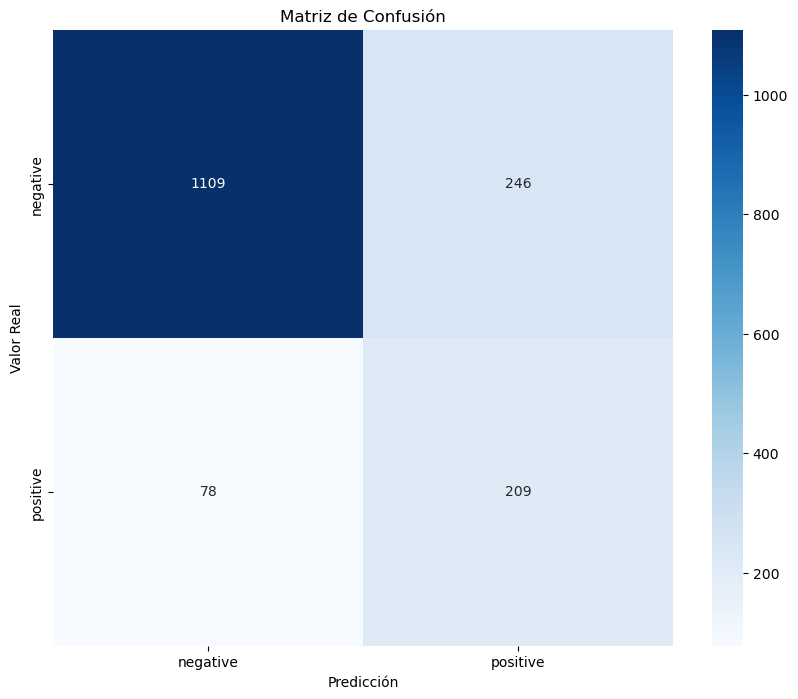

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ['negative', 'positive']

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1355
           1       0.46      0.73      0.56       287

    accuracy                           0.80      1642
   macro avg       0.70      0.77      0.72      1642
weighted avg       0.85      0.80      0.82      1642

